In [ ]:
#encoding:utf-8
"""
python版本：3.6.8(64位)
编辑器：pycharm 2020.1.3
系统：windows 10 教育版 64位
"""
import requests # 请求库，模拟浏览器请求网站（服务器）
from bs4 import BeautifulSoup # HTML 文档解析器（用于筛选我们自己想要的内容）lxml 一定要安装。
import json # 解析字典数据（字符串字典数据转成字典数据，用key取值出来）
import csv # 把爬取的数据写入到CSV中,数据类型比如 list 才能写入
import pandas as pd # 是基于NumPy 的一种工具，该工具是为解决数据分析任务而创建的
import math # 模块提供了许多对浮点数的数学运算函数。
import time # 时间处理相关的库
import random # 随机
import datetime # # 时间处理相关的库
from datetime import date # # 时间处理相关的库

today_time = datetime.datetime.now().strftime('%Y-%m-%d') # 今日日期

class wbTool():

    # def __init__(self):
    #     pass

    def extractUid(self,url):
        """
        提取UID
        :return:
        """
        ids = str(url).split('/')[-1].split('?')[0]
        return ids

    def cleaningContent(self,text):
        """
        清洗微博内容文本数据
        :param text: 微博内容
        :return:
        """

        content = str(text).replace('\n','').replace(' ','').replace('\u200b','').replace('\ue627','')
        return content
    def textCleaning(self,text):
        """
        文本清洗，微博其他文本内容清洗
        :param text:
        :return:
        """
        text = str(text).replace('\n', '').replace(' ', '')
        return text

    def basicDataProcessing(self,text):
        """
        处理转发，评论，点赞数据
        :param text:
        :return:
        """
        text = str(text).replace('转发 ','0').replace(' 转发 ','0').replace('评论','0').replace(' \n','').replace(' ','0').replace('\n','').replace('赞','0').replace('转发','0')
        return text

    def weiboTime(self,timestr):

        timestr = str(timestr).split('转赞人数超过')[0]

        if '分' in timestr:
            division = timestr.split('分')[0]
            nowtime = int(time.time()) - int(division) * 60
            timeArray = time.localtime(nowtime)
            otherStyleTime = time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
            return otherStyleTime

        if '秒' in timestr:
            division = timestr.split('秒')[0]
            nowtime = int(time.time()) - int(division)
            timeArray = time.localtime(nowtime)
            otherStyleTime = time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
            return otherStyleTime

        if '今天' in timestr:
            otherStyleTime = today_time + ' ' + str(timestr).replace('今天', '') + ':00'  # # 发布时间
            return otherStyleTime

        if '月' in str(timestr) and '年' not in str(timestr):
            releaseTime = f'{date.today().year}年' + str(timestr) + ':00'  # # 发布时间
            otherStyleTime = releaseTime.replace('日', ' ').replace('年', '-').replace('月', '-')
            return otherStyleTime

        if '年' in str(timestr) and '月' in str(timestr) and '日' in str(timestr):
            otherStyleTime = timestr.replace('日', ' ').replace('年', '-').replace('月', '-')
            releaseTime = otherStyleTime + ':00'  # # 发布时间
            return releaseTime

    def saveCsv(self,filename, content):
        "保存数据为CSV文件 list 写入"
        fp = open(f'{filename}.csv', 'a+', newline='', encoding='utf-8-sig')
        csv_fp = csv.writer(fp)
        csv_fp.writerow(content)
        fp.close()
        print(f'正在写入:{content}')

    def get_time_ranges(self,from_time, to_time, frequency):
        """
        时间转换 2
        :param from_time:
        :param to_time:
        :param frequency:
        :return:
        """
        from_time, to_time, frequency = pd.to_datetime(from_time), pd.to_datetime(to_time), frequency * 60
        time_range = list(pd.date_range(from_time, to_time, freq=f'{frequency}s'))
        if to_time not in time_range:
            time_range.append(to_time)
        time_range = [item.strftime('%Y-%m-%d %H:%M:%S') for item in time_range]
        time_ranges = []
        for item in time_range:
            f_time = item
            t_time = (datetime.datetime.strptime(item, '%Y-%m-%d %H:%M:%S') + datetime.timedelta(seconds=frequency))
            if t_time >= to_time:
                t_time = to_time.strftime('%Y-%m-%d %H:%M:%S')
                time_ranges.append([f_time, t_time])
                break
            time_ranges.append([f_time, t_time.strftime('%Y-%m-%d %H:%M:%S')])
        return time_ranges

    def weiboTime_start(self,t):
        """
        时间转换
        :param t:
        :return:
        """
        searchTime = str(t).split(':')[0].split(' ')
        dateStr = searchTime[0]
        timeStr = int(searchTime[-1])
        stime = f"{dateStr}-{timeStr}"

        return stime


class weibo_spider(wbTool):

    def __init__(self,url):

        self.url = url

    def getContent(self):
        """
        请求微博网站
        :return:
        """
        response = requests.get(self.url, headers=WEIBOCONTENT_HEADERS)  # 带上请求头模拟浏览器 请求微博内容
        if '未找到' in response.text:
            print('抱歉，未找到相关结果。')

            return None

        else:
            return response.content

    def analysisContent(self):
        """
        解析 清洗微博内容数据
        :return:
        """
        content = self.getContent() # 请求返回的数据
        if content != None:

            html = BeautifulSoup(content,'lxml')# 用BeautifulSoup 解析HTML文档。lxml库 相当于 BeautifulSoup 的芯片。
            HomePageContent = html.find('div', id="pl_feedlist_index")  # 整个内容在这个标签属性中
            try:
                weiboContent = HomePageContent.find_all('div', class_="card-wrap")  # 每个微博内容
            except:
                print('COOKIE异常,请停止程序,请刷新微博网站,重新登录之后获取COOKIE填入代码中,在重新运行程序!!!')
                print(f'当前获取开始时间是：{statrTime}')
                print(f'当前获取结束时间是：{endTime}')
                print('请修改时间,为当前已获取的时间，避免重复写入数据')
                time.sleep(60)

            else:
                for wc in weiboContent:
                    # print(wc)
                    if 'mid' in str(wc): # 排除热门文章-非搜索文章
                        nickname = wc.find('a',class_="name").text # 微博发布者昵称
                        avator = wc.find('div',class_="avator")
                        homeLink = "https:"+avator.find('a')['href'] # 个人主页链接
                        uid = self.extractUid(homeLink) # UID
                        mid = wc['mid'] # MID-->微博内容ID
                        txt = wc.find_all('p',class_="txt")[-1].text # 获取微博内容
                        txt = self.cleaningContent(txt) # 清洗微博内容
                        if '小说' in txt and '柠季' not in txt.lower():
                            pass
                        elif len(txt) > 200:
                            pass
                        else:
                            comeFrom = wc.find('p',class_="from")
                            if comeFrom == None:
                                comeFrom = wc.find('div', class_="from")
                            a2 = comeFrom.find_all('a')
                            if len(a2) == 2: # 判断是否有其他信息
                                weiboDetailedLink = "https:"+comeFrom.find('a',target="_blank")['href'] # 微博详细链接
                                publishingDevice = comeFrom.find('a',rel="nofollow").text # 发布来源
                            else:
                                weiboDetailedLink = "https:" + comeFrom.find('a', target="_blank")['href']  # 微博详细链接
                                publishingDevice = "NULL" # 如果没有显示发布来源，就设置为NULL
                            releaseTime = comeFrom.find('a',target="_blank").text # 发布微博时间
                            releaseTime = self.textCleaning(releaseTime) # 发布微博时间
                            releaseTime = self.weiboTime(releaseTime) # 发布微博时间
                            basicData = wc.find('div',class_="card-act").find_all('li')
                            if len(basicData) == 3:
                                basicData = basicData
                            elif len(basicData) >= 4:
                                basicData = basicData[1:]
                            basicDatalist = [int(self.basicDataProcessing(bd.text)) for bd in basicData] # 转发数,评论数,点赞数

                            # UID,MID,发布时间，微博内容，微博链接，发布者昵称，发布来源，主页链接，转发数，评论数，点赞数
                            essentialInformation = [uid+'\t',mid+'\t',releaseTime,txt,weiboDetailedLink,nickname,publishingDevice,homeLink,] + basicDatalist
                            # 昵称、性别、粉丝数、关注数、所属地址(IP)、微博数、是否认证、头像下载链接、媒体类型、log10,认证类型
                            blogger = self.GetBloggerinfo(uid)
                            data = essentialInformation + blogger
                            self.saveCsv(FILENAMES,data)

                            if judge == 'y' or judge == 'Y': # 刚开始运行程序的时候，判断输入是否要爬去评论。
                                self.getComment(mid,uid,max_id=0)

                try:
                    pages = html.find('ul', class_="s-scroll").find_all('a')
                except:
                    pass
                else:
                    pages = len(pages)  # 获取搜索关键词信息有多少页，总页码数
                    try:
                        nextPage = html.find('a', class_="next")  # 筛选出下一页的跳转链接，也就是我们爬取的链接，标签 a 属性为 class_="next"
                        nextPageJudgment = str(nextPage['href']).split('=')[-1]  # 筛选出下一页的页码数
                        if int(nextPageJudgment) > int(pages):  # 如果下一页页码 大于 总 页码数，就停止爬取。
                            pass
                        else:  # 否则就继续爬取
                            print(f'正在获取第 {nextPageJudgment} 页')
                            nextPage = 'https://s.weibo.com' + nextPage['href']
                            # self.getWeibo_content(nextPage)
                            weibo_spider(nextPage).analysisContent()
                    except:
                        pass


    def GetBloggerinfo(self,uid):

        """
        请求博主基本信息
        :return:
        """
        url = f'https://weibo.com/ajax/profile/info?uid={uid}'

        try:
            response = requests.get(url, headers=ASYNCHRONOUS_HEADERS)  # 带上请求头模拟浏览器 请求微博内容
            jsondata = json.loads(response.text)
            # data = jsondata['data']
            # print(jsondata)
        except:

            data = ['', '', '', '', '',
                        '', '', '', '', '', '','']
            return data
        else:
            if jsondata['ok'] == 1 or jsondata['ok'] == '1':
                data = jsondata['data']
                user = data['user']
                screen_name = user['screen_name']  # 搜索名称(作者昵称)
                description = user['description']  # 个性签名
                followers_count = user['followers_count']  # 粉丝数
                friends_count = user['friends_count']  # 关注数
                location = user['location']  # IP所属地址
                statuses_count = user['statuses_count']  # 动态数(微博数量)
                verified = user['verified']  # 是否认证
                avatar_large = user['avatar_large']  # 头像
                gender = user['gender']  # 性别 m/f
                if gender == 'm':
                    gender = '男'
                else:
                    gender = '女'
                if int(followers_count) > 10000:
                    publicMedia = '公共媒体'
                    log10 = math.log10(int(followers_count))
                else:
                    publicMedia = 'nan'
                    log10 = 'nan'
                if str(verified) == 'True':
                    verified_type_ext = user['verified_type_ext']  # 认证V
                    verified_type = user['verified_type']  # 认证V
                    if int(verified_type_ext) == 1 and int(verified_type) == 0:
                        memberType = '微博个人认证(红V)'
                    elif int(verified_type) == 3:
                        memberType = '微博官方认证(蓝V)'
                    elif int(verified_type) == 0 and int(verified_type_ext) == 0:
                        memberType = '微博个人认证(黄V)'
                    else:
                        memberType = ''
                    # 昵称、性别、粉丝数、关注数、所属地址(IP)、微博数、是否认证、头像下载链接、媒体类型、log10,认证类型
                    data = [screen_name, gender, description, followers_count, friends_count,
                                location, statuses_count, verified, avatar_large, publicMedia, log10, memberType]
                    return data
                else:
                    memberType = '无认证'
                    # 昵称、性别、粉丝数、关注数、所属地址(IP)、微博数、是否认证、头像下载链接、媒体类型、log10,认证类型
                    data = [screen_name, gender, description, followers_count, friends_count,
                            location, statuses_count, verified, avatar_large, publicMedia, log10,memberType]
                    return data

            else:
                data = ['', '', '', '', '',
                        '', '', '', '', '', '', '']
                return data

    def getComment(self,mid,uid,max_id,page=0):
        """
        抓取评论 只有一级评论
        :return:
        """
        url = 'https://weibo.com/ajax/statuses/buildComments?'
        parameter = {

            'is_asc': '0',
            'is_reload': '1',
            'id': mid,
            'is_show_bulletin': '1',
            'is_mix': '0',
            'max_id': max_id, # 用于翻页。
            'count': '20',
            'uid': uid,
            'fetch_level': '0',

        }
        result = requests.get(url,params=parameter,headers=ASYNCHRONOUS_HEADERS)
        # print(result.text)
        jsondata = json.loads(result.text)
        # print(jsondata)
        if jsondata['ok'] == 1 or jsondata['ok'] == '1':
            data = jsondata['data']
            total_number = jsondata['total_number']
            print(f'一共有{total_number}评论')
            for d in data:
                created_at = d['created_at']  # 评论时间
                struct_time = time.strptime(created_at, '%a %b %d %H:%M:%S %z %Y')  # 评论时间
                time_array = time.strftime("%Y-%m-%d %H:%M:%S", struct_time)  # 评论时间
                text_raw = d['text_raw'] # 评论内容
                user = d['user']
                comment_userid = user['id']
                screen_name = user['screen_name'] # 评论用户昵称
                description = user['description'] # 评论用户签名
                followers_count = user['followers_count'] # 关注数量
                friends_count = user['friends_count'] # 粉丝数量
                try:
                    like_counts = d['like_counts']  # 评论点赞数
                except:
                    like_counts = 0
                statuses_count = user['statuses_count'] # 作品数
                location = user['location'] # IP所属

                data = [mid+'\t',uid+'\t',time_array,text_raw,comment_userid,screen_name,description,followers_count,friends_count,like_counts,statuses_count,location,self.url]
                self.saveCsv(COMMENT_FILENAME,data)

            if data != []:
                max_id = jsondata['max_id']
                if max_id == 0 or max_id == '0':
                    pass
                else:
                    page += 1
                    page_count = total_number / 10
                    if page > page_count:
                        pass
                    else:
                        print(f'正在爬取第{page}页,评论数据中...')
                        t = random.randint(6,20)
                        print(f'休息{t}秒后继续爬取下页评论')
                        time.sleep(t)
                        self.getComment(mid, uid, max_id, page)
            else:
                print(jsondata['trendsText'])

if __name__ == '__main__':

    # 换上自己的COOKIE

    COOKIES = 'SINAGLOBAL=7473514271233.481.1698491153343; UOR=,,link.zhihu.com; ULV=1699281096637:2:1:1:3302992385513.2812.1699281096633:1698491153353; ALF=1711962173; SUB=_2A25I5ptsDeRhGeFN61EQ9ifKzTuIHXVrnZKkrDV8PUJbkNAbLRTZkW1NQJ1Y13fq8fJ-fzeud4O5kQCXOigRbPlX; SUBP=0033WrSXqPxfM725Ws9jqgMF55529P9D9WFlEe_vDQgflmfqE1Xw8pbK5JpX5KzhUgL.FoM0ehepSo.cSoM2dJLoI74Fqg4rqPiydJMceKzXS5tt'

    WEIBOCONTENT_HEADERS = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'zh-CN,zh;q=0.9',
        'cache-control': 'max-age=0',
        # 这里最重要的就是COOKIE，需要登录后爬取，不用担心封号。
        'cookie': COOKIES,
        # USER-Agent 是伪装自己是可视化浏览器，非机器人。
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36',
    }

    ASYNCHRONOUS_HEADERS = {
        'accept': 'application/json, text/plain, */*',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'zh-CN,zh;q=0.9',
        'client-version': 'v2.40.12',
        'cookie': COOKIES,
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',

    }

    from_time = '2023-02-28 00:00:00'  # 爬取的开始时间
    to_time = '2024-2-28 23:59:59'  # 爬取的结束时间
    frequency = 60 * 6  # 分钟 爬取间隔时间 1天 24*60=
    """
    间隔时间：
        微博有限制50页，1月1日-2日的微博数据，1日00：00-02：00 ==50页，2-4点，也有50页，4-6点也有。00：00-23：59分。
        12个2小时，12*50页 = 600页。
    """
    keyword = '柠季'  # 关键词

    print(keyword)

    FILENAME = "_".join(keyword)

    # 文件名称
    FILENAMES = f'{FILENAME}2023.02.28-2024.02.28'

    # 评论文件名称
    COMMENT_FILENAME = f'{FILENAME}评论2023.02.28-2024.02.28'


    col = ['UID', 'MID', '发布时间', '微博内容', '微博链接', '发布者昵称', '发布来源', '主页链接', '转发数', '评论数', '点赞数', '博主昵称', '性别', '个人签名',
           '粉丝数', '关注数', '所属IP地址', '微博数',
           '是否认证', '头像链接', '媒体类型', 'log10', '认证类型']

    wbTool().saveCsv(FILENAMES, col)
    # print('程序准备开始运行')

    comment_col = ['MID', 'UID', '评论时间', '评论内容', '评论人UID', '评论人昵称', '评论人个性签名', '关注数量', '粉丝数量', '点赞数量', '作品数', 'IP所属','微博链接']

    wbTool().saveCsv(COMMENT_FILENAME, comment_col)

    remind = """
       请回答是否要抓取评论数据，如果要抓评论内容，请输入y。
       提醒评论数据是单独的文件，并没有与微博内容文件合并，抓完数据需要用MID字段自行匹配对应微博。
        
        1、评论数据并不是显示多少就能抓取多少，例如一共6条评论只抓取3条的原因: 
            1) 微博主动屏蔽了非法关键词;
            2) 一级评论是有3条，其他3条可能是二级评论或者三级评论;
            3) 微博限制显示条数;
        2、评论只抓取一级评论。如需要二级评论需要自己修改代码。
        3、直接运行报错请检查是否填入COOKIE。requests,bs4,lxml包是否安装。
       """

    print(remind)
    # judge = input('是否要抓取评论数据[y/n]：')
    judge = 'y'
    Sleeptime_count = 0
    k = wbTool().get_time_ranges(from_time, to_time, frequency)
    for x in k:
        print(f'\n正在爬取时间段为:{str(x[0])}~{str(x[-1])}')
        statrTime =  wbTool().weiboTime_start(str(x[0]))
        endTime =  wbTool().weiboTime_start(str(x[-1]))
        Sleeptime_count += 1
        '随机延迟，尝试反爬取'
        if Sleeptime_count % 6 == 0:
            print('\n短暂休息一下 随机休息5--20秒\n')
            time.sleep(random.randint(5,20))

        print(f'\n正在爬取关键词为:{keyword}的数据')
        url = f'https://s.weibo.com/weibo?q={keyword}&typeall=1&suball=1&timescope=custom:{statrTime}:{endTime}&Refer=g'
        #url = 'https://weibo.com/3167104922/Kkl7ar83T#comment'
        weibo_spider(url).analysisContent()
#第一条微博2021-5-31


In [5]:
import re
import jieba
import collections
import openpyxl
import stylecloud
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from snownlp import SnowNLP # 此处使用snownlp模块对评论进行情感分析
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import geopandas as gpd


In [28]:
import numpy as np
import re,jieba
from itertools import chain
from snownlp import SnowNLP # 此处使用snownlp模块对评论进行情感分析

import pandas as pd
import jieba

# 读取包含中文文本的数据
data = pd.read_excel("D:/市调/工作内容.xlsx", header=0)
data = data.applymap(lambda x: x.upper() if isinstance(x, str) else x)
# 停用词列表，可以根据需求扩展
stoplist= [word.strip() for word in open('stopwords.txt',encoding='utf-8').readlines()]

custom_words = [
    '海底椰',
    'linlee',
    '手打柠檬茶',
    '大绿鸭',
    '椰汁青柠',
    '盒马',
    '霸王茶姬',
    '鸭屎香',
    '冰柠',
    '好喝',
    '一点点',
    '小黄鸭',
    '柠季',
    '曾舜晞'
    # 添加更多的自定义词组...
]

# 将自定义词组添加到jieba的词典中
for word in custom_words:
    jieba.add_word(word)

# 定义分词函数，并过滤停用词
def tokenize_text(text):
    # 使用jieba进行分词
    tokens = jieba.lcut(text)
    # 过滤掉空格和停用词
    tokens = [token.strip() for token in tokens if token.strip() and token.strip() not in stoplist]
    return tokens

# 对数据中的文本列应用分词函数
data['tokenized_text'] = data['评论'].apply(tokenize_text)

In [29]:

df = data
def remove(text):
    text1 = re.sub(r'[^\w\s]','', text)
    text2 = re.sub(r'\d+','', text1)
    data = ''.join([item for item in text2])
    text3 = re.findall('[\u4e00-\u9fa5]+', data, re.S)
    text4 = "".join(text3)
    return text4
data['评论'] = data['评论'].apply(remove)
data['score_pl']=data['评论'].apply(lambda x: SnowNLP(x).sentiments)
#data = data[data['score_pl'] != 1.0]


In [25]:
data

,昵称,性别,IP,评论,点赞,tokenized_text,score_pl
0,三三年二月十六日,保密,IP属地：天津,那个帷幕拉起来然后宝玉一愣回头看的时候委屈我流眼泪了谁懂大哭各位姐姐妹妹们原来在这里让我好生...,29896,"[帷幕, 拉, 起来, 宝玉, 愣, 回头, 看, 委屈, 流眼泪, 懂, 大哭, 姐姐, ...",0.996582
1,500D9,保密,IP属地：湖北,即使是要表现奢靡繁华纸醉金迷的极盛时期的贾府舞台上的色彩饱和度也不是很高反而有一种古典的朦胧...,5694,"[表现, 奢靡, 繁华, 纸醉金迷, 极盛时期, 贾府, 舞台, 色彩, 饱和度, 不是, ...",0.999996
2,皮皮啊乐乐啊,女,IP属地：陕西,一场盛大华丽凄美残酷的落幕每个人走向的是坏死不是凋亡,2862,"[一场, 盛大, 华丽, 凄美, 残酷, 落幕, 每个, 人, 走向, 坏死, 不是, 凋亡]",0.999148
3,IVY510602,保密,IP属地：广东,那高椅背不是像墓碑而是像牌位,9374,"[那高, 椅背, 不是, 墓碑, 牌位]",0.205405
4,雷暴中的星星,女,IP属地：江苏,这个故事本身就是全员因为知道所以我并不想看第二遍但是在我心里其实很希望更多人去看看红楼梦不单...,15464,"[故事, 本身, 全员, BE, 知道, 不想, 看, 第二遍, 心里, 其实, 希望, 更...",0.999932
5,天莨菪碱,女,IP属地：北京,妈呀有幸在国家大剧院看过这个表演真的绝了没想到舞剧也将红楼梦这一文学作品的内核表现得淋漓尽致...,1513,"[妈呀, 有幸, 国家大剧院, 看过, 表演, 真的, 绝, 没想到, 舞剧, 红楼梦, 这...",0.999978
6,浮世淸和,保密,IP属地：江苏,从暖场哭到散场我本人笑哭,2566,"[从暖场, 哭, 散场, 本人, 笑, 哭]",0.940631
7,阿菁_ARIA,女,IP属地：北京,我本人的人生之书从幼时读到现在随意打开一个章节就会如痴如醉读到结尾真的希望可以在这个快节奏的...,574,"[本人, 人生, 书, 幼时, 读, 现在, 随意, 打开, 章节, 会, 如痴如醉, 读,...",1.000000
8,前朝不良人-天穷星,保密,IP属地：黑龙江,我的天封面那个镜头给我看的鼻子酸了想哭不知道为啥就是感觉被震撼住了果然真的艺术就算我这种初中...,993,"[天, 封面, 镜头, 看, 鼻子, 酸, 想, 哭, 知道, 为啥, 感觉, 震撼, 住,...",0.885764
9,布鲁斯扬,男,IP属地：四川,一舞红楼一梦春秋太虚幻境十二金钗怡红公子枉自嗟叹浮生着甚苦奔忙盛席华宴终散场悲喜千般同幻渺古...,1626,"[一舞, 红楼, 一梦, 春秋, 太虚幻境, 十二金钗, 怡红, 公子, 枉自, 嗟叹, 浮...",1.000000


In [26]:
data.to_excel('output.xlsx', index=False)

In [17]:
# 定义分词函数
def tokenize(text):
    return " ".join(jieba.cut(text))
object_list = df['评论'].apply(tokenize)
df['评论分词'] = df['评论'].apply(tokenize)
negPath = r"负面情绪词.txt"
posPath = r"正面情绪词.txt"
pos = open(posPath, encoding='utf-8').readlines()
neg = open(negPath, encoding='utf-8').readlines()
#统计积极、消极词
for i in range(len(pos)):
    pos[i] = pos[i].replace('\n','').replace('\ufeff','')
for i in range(len(neg)):
    neg[i] = neg[i].replace('\n','').replace('\ufeff','')

# 假设 df 是包含评论内容的 DataFrame，评论内容所在列名为 '分词后的评论内容'
# 将评论内容分词，并转换为列表
tokenized_comments = df['评论分词'].apply(lambda x: x.split())
 
# 初始化正面词和负面词的词频字典
pos_word_freq = {}
neg_word_freq = {}
 
# 遍历分词结果列表，计算正面词和负面词的词频
for tokens in tokenized_comments:
    for token in tokens:
        if token in pos:
            pos_word_freq[token] = pos_word_freq.get(token, 0) + 1
        elif token in neg:
            neg_word_freq[token] = neg_word_freq.get(token, 0) + 1
 
# 将词频字典转换为 pandas Series
pos_word_freq_series = pd.Series(pos_word_freq).sort_values(ascending=False)
neg_word_freq_series = pd.Series(neg_word_freq).sort_values(ascending=False)
 
# 显示正面词和负面词的词频分布
print("正面词词频分布：")
print(pos_word_freq_series)
print("\n负面词词频分布：")
print(neg_word_freq_series)
pos_word_freq_series.to_excel("积极.xlsx")
neg_word_freq_series.to_excel("消极.xlsx")


正面词词频分布：
Series([], dtype: object)

负面词词频分布：
Series([], dtype: object)


In [19]:
tokenized_comments = df['评论分词'].apply(lambda x: x.split())

In [20]:
tokenized_comments

0     [那个, 帷幕, 拉, 起来, 然后, 宝玉, 一, 愣, 回头, 看, 的, 时候, 委屈...
1     [即使, 是, 要, 表现, 奢靡, 繁华, 纸醉金迷, 的, 极盛时期, 的, 贾府, 舞...
2     [一场, 盛大, 华丽, 凄美, 残酷, 的, 落幕, 每个, 人, 走向, 的, 是, 坏...
3                        [那高, 椅背, 不是, 像, 墓碑, 而是, 像, 牌位]
4     [这个, 故事, 本身, 就是, 全员, 因为, 知道, 所以, 我, 并, 不想, 看, ...
5     [妈呀, 有幸, 在, 国家大剧院, 看过, 这个, 表演, 真的, 绝, 了, 没想到, ...
6                          [从暖场, 哭, 到, 散场, 我, 本人, 笑, 哭]
7     [我, 本人, 的, 人生, 之书, 从, 幼时, 读, 到, 现在, 随意, 打开, 一个...
8     [我, 的, 天, 封面, 那个, 镜头, 给, 我, 看, 的, 鼻子, 酸, 了, 想,...
9     [一舞, 红楼, 一梦, 春秋, 太虚幻境, 十二金钗, 怡红, 公子, 枉自, 嗟叹, 浮...
10    [稍微, 安利, 一下, 中央芭蕾舞团, 的, 红楼梦, 是, 今年, 二月, 刚, 在, ...
11                                     [千红, 一哭, 万艳, 同悲]
12                      [这一水, 的, 中国, 古典, 配色, 服饰, 好, 亮眼]
13                               [终究, 是, 一场, 繁华, 梦, 罢了]
14                     [四月, 西安, 场, 在, 第一排, 贴, 贴, 星星, 眼]
15    [你, 把, 马克思, 拖, 过来, 看, 红楼梦, 然后, 让, 他, 去, 分析, 红楼...
16    [有幸, 看到, 了, 成都, 场, 加场, 的, 演出, 给, 心心, 特地, 从, 太原...
17                                 [荣辱兴衰, 不过, 大,

Text(0.5, 1.0, 'Histogram of Score PL')

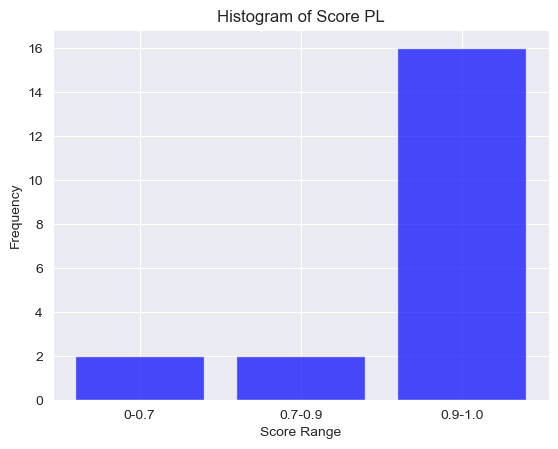

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 假设data是一个包含'score_pl'列的DataFrame
# 如果data还没有被定义，可以使用以下代码生成示例数据
import pandas as pd

# 定义分箱区间
bins = [0, 0.7, 0.9, 1.0]
labels = ['0-0.7', '0.7-0.9', '0.9-1.0']

# 将'score_pl'分箱
data['binned'] = pd.cut(data['score_pl'], bins=bins, labels=labels, include_lowest=True)

# 计算每个区间的频数
bin_counts = data['binned'].value_counts().reindex(labels)

# 绘制柱状图
plt.bar(bin_counts.index, bin_counts.values, color='blue', alpha=0.7)
plt.xlabel('Score Range')
plt.ylabel('Frequency')
plt.title('Histogram of Score PL')
#plt.show()


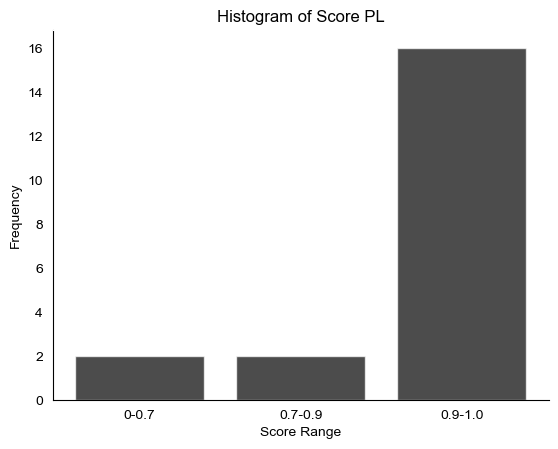

In [40]:
data['binned'] = pd.cut(data['score_pl'], bins=bins, labels=labels, include_lowest=True)

# 计算每个区间的频数
bin_counts = data['binned'].value_counts().reindex(labels)

# 绘制柱状图
fig, ax = plt.subplots()

# 设置背景颜色为白色，字体颜色为黑色
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.yaxis.label.set_color('black')
ax.xaxis.label.set_color('black')
ax.title.set_color('black')

ax.bar(bin_counts.index, bin_counts.values, color='black', alpha=0.7)
ax.set_xlabel('Score Range')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Score PL')
plt.savefig('bar_chart.jpg', format='jpg')
plt.show()


In [39]:
plt.savefig('bar_chart.jpg', format='jpg')

<Figure size 640x480 with 0 Axes>

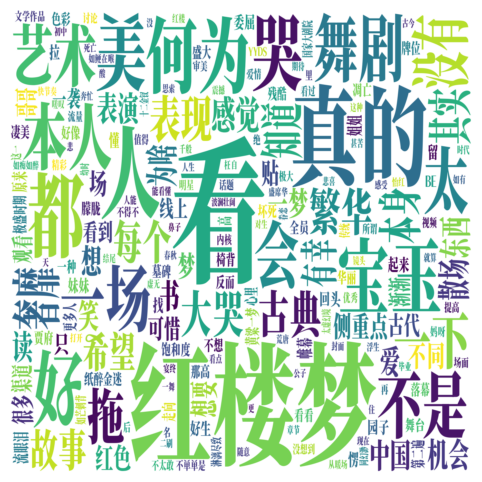

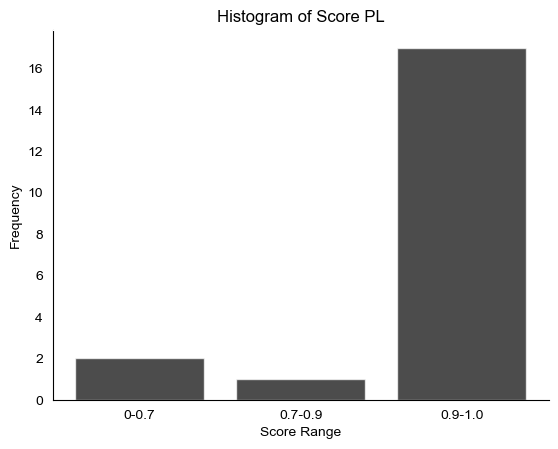

In [8]:
import numpy as np
import re,jieba
from itertools import chain
from snownlp import SnowNLP # 此处使用snownlp模块对评论进行情感分析
import wordcloud
import pandas as pd
import jieba
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

# 读取包含中文文本的数据
data = pd.read_excel("D:/市调/工作内容.xlsx", header=0)
data = data.applymap(lambda x: x.upper() if isinstance(x, str) else x)
# 停用词列表，可以根据需求扩展
stoplist= [word.strip() for word in open('stopwords.txt',encoding='utf-8').readlines()]

# 定义分词函数，并过滤停用词
def tokenize_text(text):
    # 使用jieba进行分词
    tokens = jieba.lcut(text)
    # 过滤掉空格和停用词
    tokens = [token.strip() for token in tokens if token.strip() and token.strip() not in stoplist]
    return tokens

# 对数据中的文本列应用分词函数
data['tokenized_text'] = data['评论'].apply(tokenize_text)

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
# 合并所有分词结果为一个列表
all_tokens = [token for sublist in data['tokenized_text'] for token in sublist]

# 统计词频
word_freq = Counter(all_tokens)

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
# 合并所有分词结果为一个列表
all_tokens = [token for sublist in data['tokenized_text'] for token in sublist]

# 统计词频
word_freq = Counter(all_tokens)

wordcloud = WordCloud(font_path="猴尊宋体.ttf",background_color="white",width=1800,height=1800, margin=5).generate_from_frequencies(word_freq)
#wordcloud = WordCloud(font_path="猴尊宋体.ttf",background_color="white",mask=mask_array,width=1800,height=1800, margin=5).generate_from_frequencies(word_freq)
# 显示词云图
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud.png")


def remove(text):
    text1 = re.sub(r'[^\w\s]','', text)
    text2 = re.sub(r'\d+','', text1)
    data = ''.join([item for item in text2])
    text3 = re.findall('[\u4e00-\u9fa5]+', data, re.S)
    text4 = "".join(text3)
    return text
df = data
data['评论'] = data['评论'].apply(remove)
data['score_pl']=data['评论'].apply(lambda x: SnowNLP(x).sentiments)


bins = [0, 0.7, 0.9, 1.0]
labels = ['0-0.7', '0.7-0.9', '0.9-1.0']
data['binned'] = pd.cut(data['score_pl'], bins=bins, labels=labels, include_lowest=True)

# 计算每个区间的频数
bin_counts = data['binned'].value_counts().reindex(labels)

# 绘制柱状图
fig, ax = plt.subplots()

# 设置背景颜色为白色，字体颜色为黑色
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.yaxis.label.set_color('black')
ax.xaxis.label.set_color('black')
ax.title.set_color('black')

ax.bar(bin_counts.index, bin_counts.values, color='black', alpha=0.7)
ax.set_xlabel('Score Range')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Score PL')
plt.savefig('bar_chart.jpg', format='jpg')
plt.show()
